In [4]:
# Comparison of different model architectures
import torchaudio

from util import get_root_path
import util
import torch
from data import AudioDataloader, MSPPodcast
from config import load_hydra_config
from IPython.display import Audio
import matplotlib.pyplot as plt

from models import HifiGAN, models_from_config


cfg = load_hydra_config("vc_xlsr", overrides=["data.dataset.segment_size=70000"])
dataloader = AudioDataloader(
    dataset=MSPPodcast(cfg.data, split="development", random_segmentation=False),
    cfg=cfg.data.dataloader,
    batch_size=1,
    shuffle=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocoder = HifiGAN(cfg.model.vocoder).to(device)
util.load_model(vocoder, "hifigan.pth", freeze=True)

x = torchaudio.load(get_root_path() / "sample" / "src.wav")[0].to(device)
Audio(x.detach().cpu(), rate=cfg.data.dataset.sampling_rate)

t = torchaudio.load(get_root_path() / "sample" / "trg.wav")[0].to(device)
Audio(t.detach().cpu(), rate=cfg.data.dataset.sampling_rate)


checkpoints = {
    "vc_xlsr": get_root_path() / "ckpt" / "vc_xlsr.pth",
    "vc_xlsr_ph_yin": get_root_path() / "ckpt" / "vc_xlsr_ph_yin.pth",
    "vc_xlsr_yin": get_root_path() / "ckpt" / "vc_xlsr_yin.pth",
    "evc_xlsr_yin": get_root_path() / "ckpt" / "evc_xlsr_yin.pth",
    "tkn_evc_xlsr_yin": get_root_path() / "ckpt" / "ckpt_e14_b392.pth",
}


def plot_model_output(
    x_audio,
    cfg_name,
    t_audio=None,
    emo_level: int = None,
    pitch_shift: bool = False,
):
    if cfg_name not in checkpoints:
        raise ValueError(f"Checkpoint for {cfg_name} not found.")

    # Load config and models
    cfg = load_hydra_config(cfg_name)
    model, preprocessor, style_encoder = models_from_config(cfg, device)

    # Load checkpoint
    ckpt = torch.load(checkpoints[cfg_name], map_location=device, weights_only=False)

    model.load_state_dict(ckpt["model"])
    model.requires_grad_(False)
    model.eval()

    preprocessor.load_state_dict(ckpt["preprocessor"])
    preprocessor.requires_grad_(False)
    preprocessor.eval()

    style_encoder.load_state_dict(ckpt["style_encoder"])
    style_encoder.requires_grad_(False)
    style_encoder.eval()

    # Forward pass
    x = preprocessor(x_audio)

    if t_audio is not None:
        t = preprocessor(t_audio)
        if emo_level is not None:
            g = style_encoder.emotion_conversion(t, emo_level).unsqueeze(-1)
        else:
            g = style_encoder(t).unsqueeze(-1)
        if pitch_shift:
            x.emb_pitch = preprocessor.pitch_encoder.yin_with_pitch_shift(
                x.audio, t.audio
            )
    else:
        if emo_level is not None:
            g = style_encoder.emotion_conversion(x, emo_level).unsqueeze(-1)
        else:
            g = style_encoder(x).unsqueeze(-1)

    y_mel = model(x, g, n_time_steps=50)
    y_mel = y_mel[:, :, :-3]

    # Vocode
    y = vocoder(y_mel).squeeze(1)

    # Plot
    fig, axs = plt.subplots(2, figsize=(12, 8))
    axs[0].imshow(x.mel[0].cpu().numpy(), origin="lower")
    axs[0].set_title("Input mel spectrogram")
    axs[1].imshow(y_mel[0].cpu().numpy(), origin="lower")
    axs[1].set_title("Output mel spectrogram")

    plt.tight_layout()
    plt.show()

    # Save audio
    display(Audio(x_audio.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    if t_audio is not None:
        display(Audio(t_audio.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
    display(Audio(y.detach().cpu(), rate=cfg.data.dataset.sampling_rate))

In [5]:
display(Audio(x.detach().cpu(), rate=cfg.data.dataset.sampling_rate))
display(Audio(t.detach().cpu(), rate=cfg.data.dataset.sampling_rate))

## Resynthesis

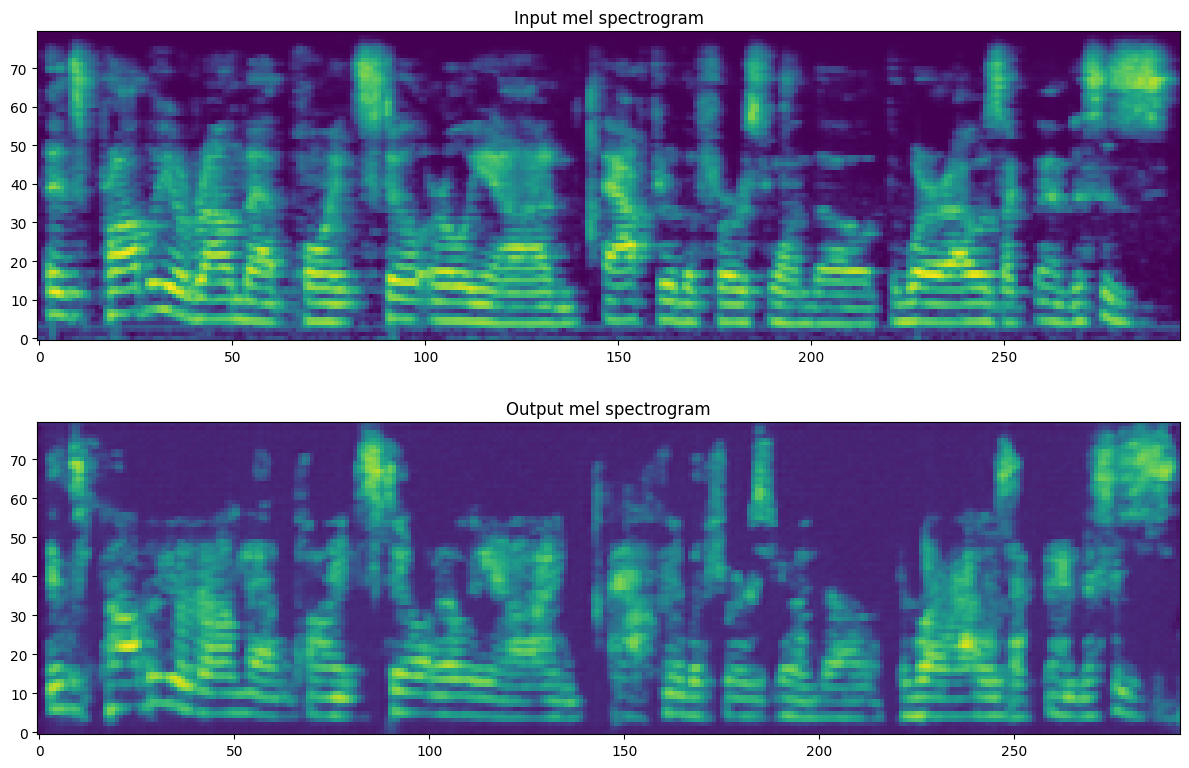

In [6]:
plot_model_output(x, "tkn_evc_xlsr_yin")

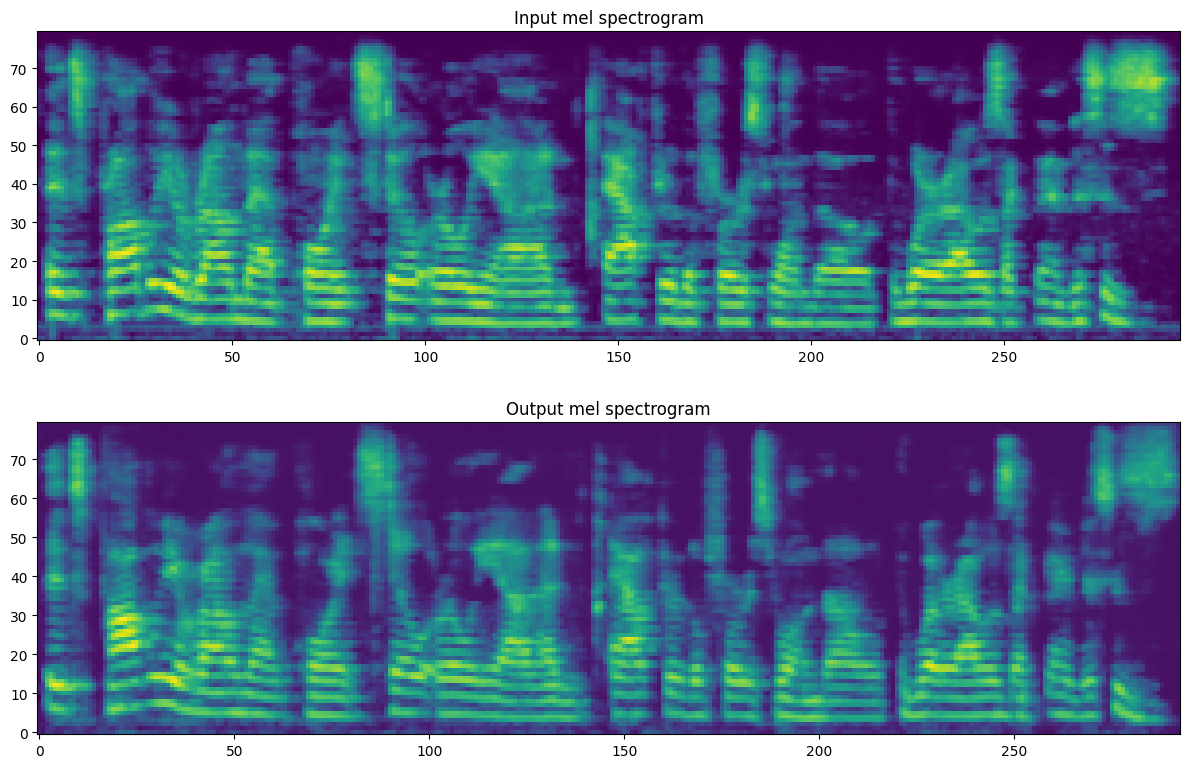

In [7]:
plot_model_output(x, "evc_xlsr_yin")

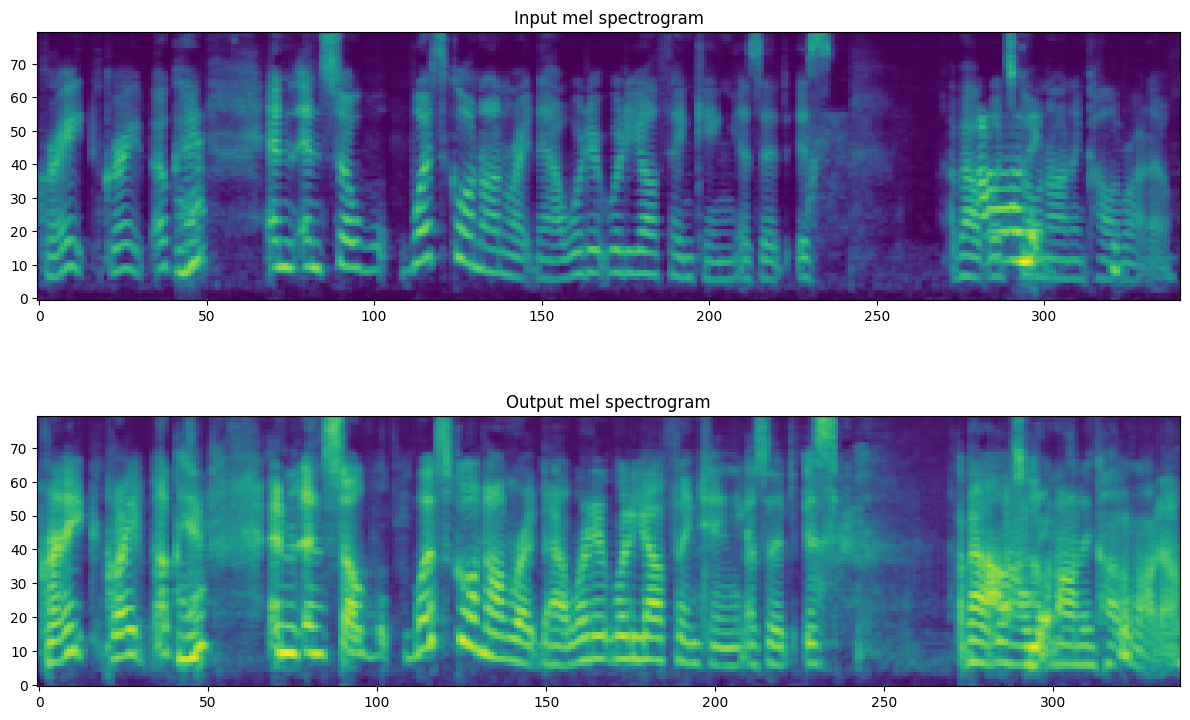

In [8]:
plot_model_output(t, "tkn_evc_xlsr_yin")

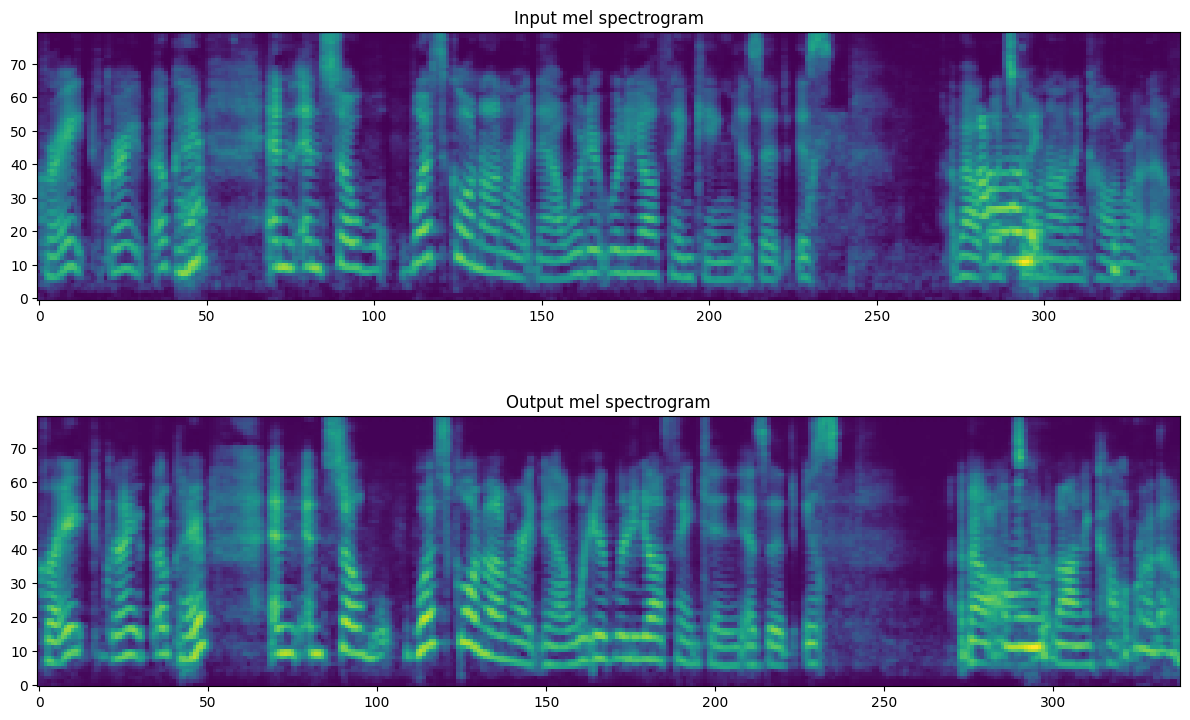

In [9]:
plot_model_output(t, "evc_xlsr_yin")

## Speaker Conversion

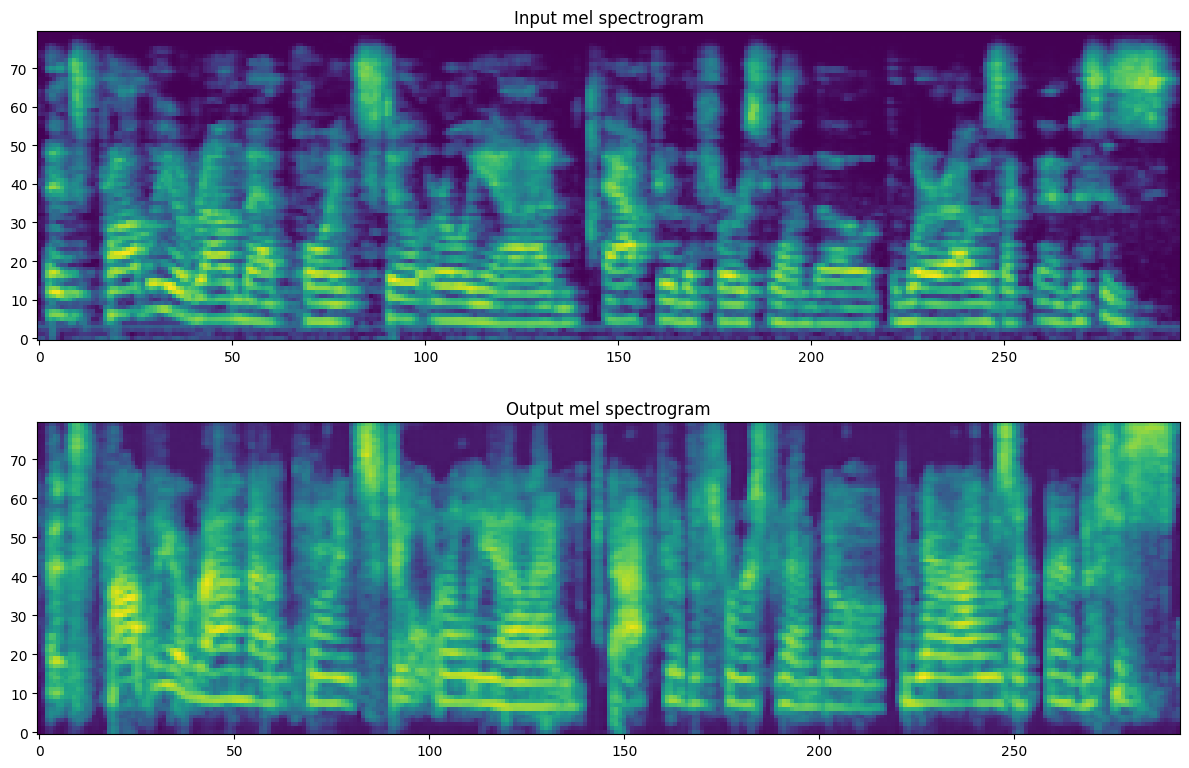

In [10]:
plot_model_output(x, "tkn_evc_xlsr_yin", t, pitch_shift=True)

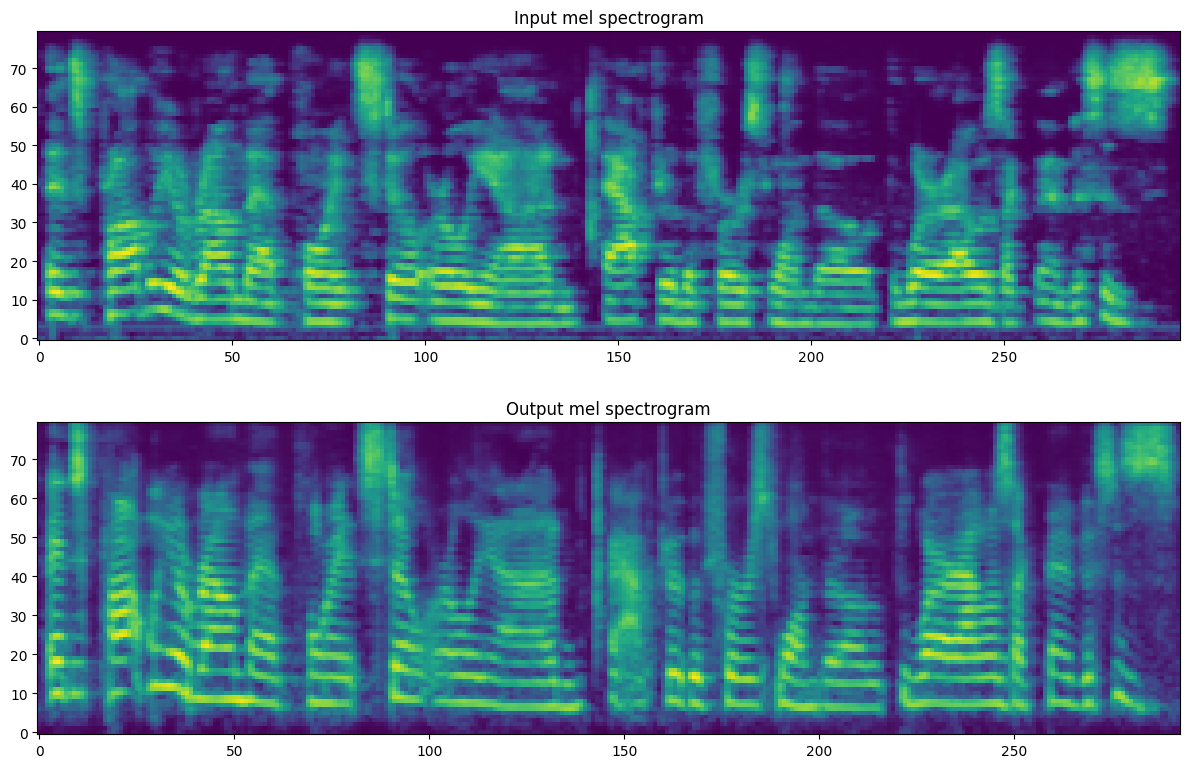

In [11]:
plot_model_output(x, "evc_xlsr_yin", t, pitch_shift=True)

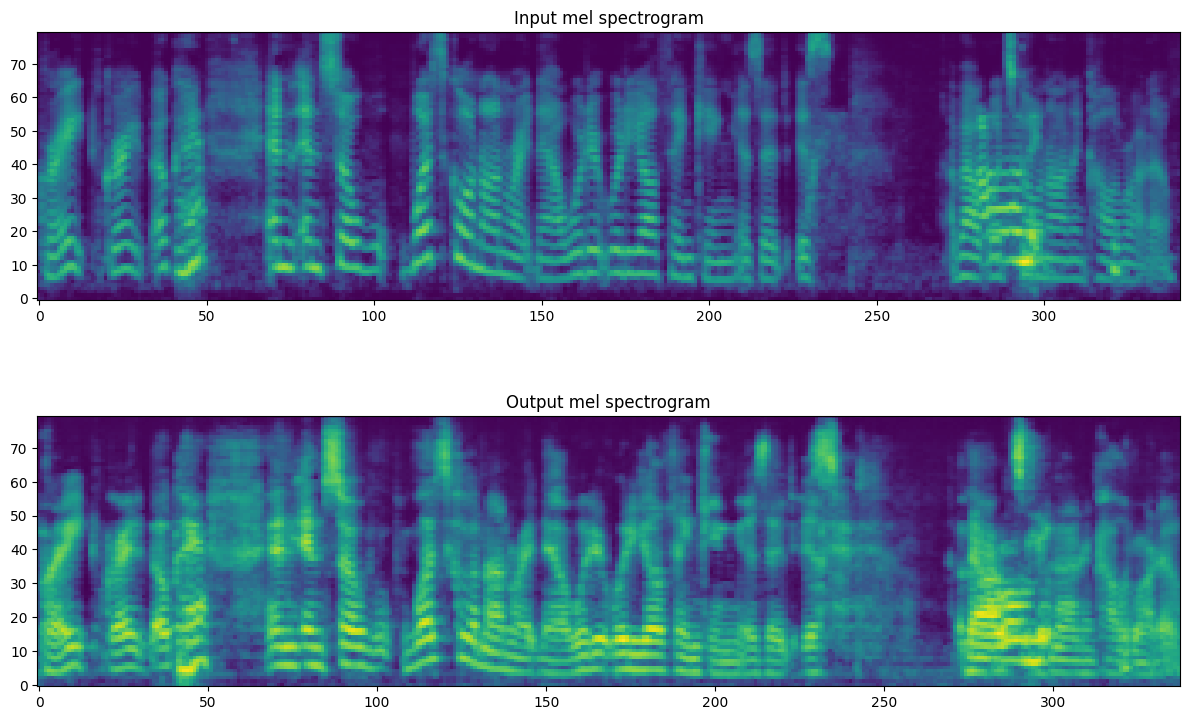

In [12]:
plot_model_output(t, "tkn_evc_xlsr_yin", x, pitch_shift=True)

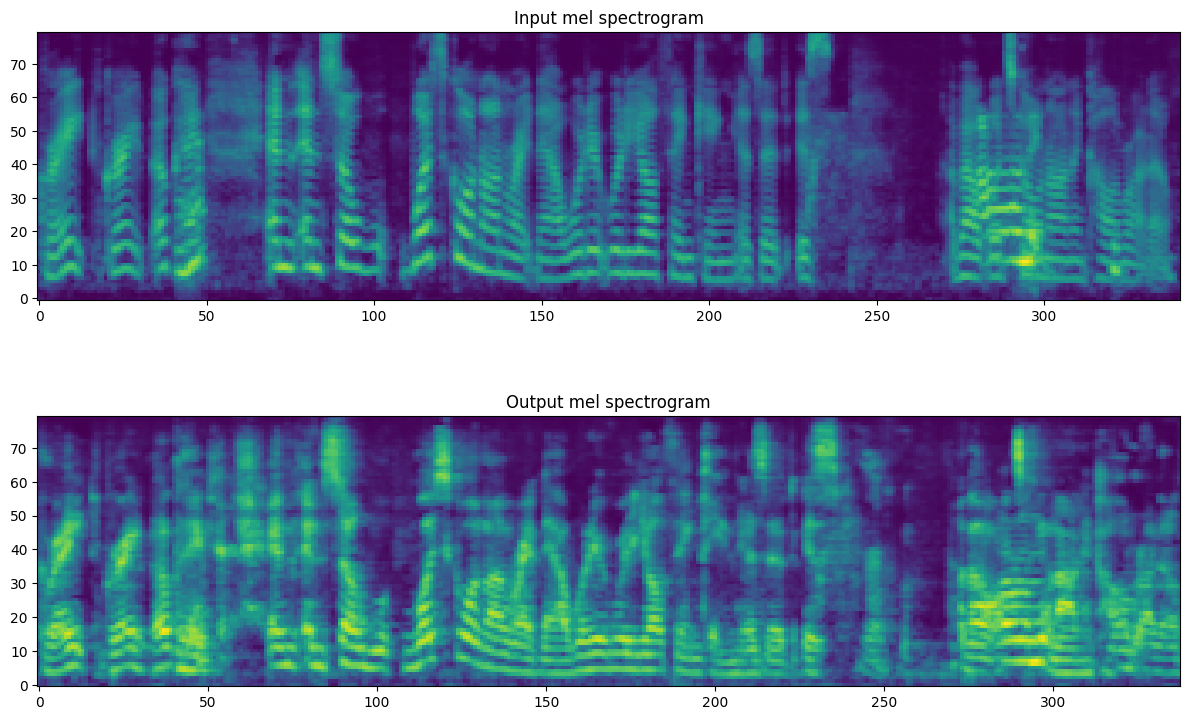

In [13]:
plot_model_output(t, "evc_xlsr_yin", x, pitch_shift=True)

## Emotion Control

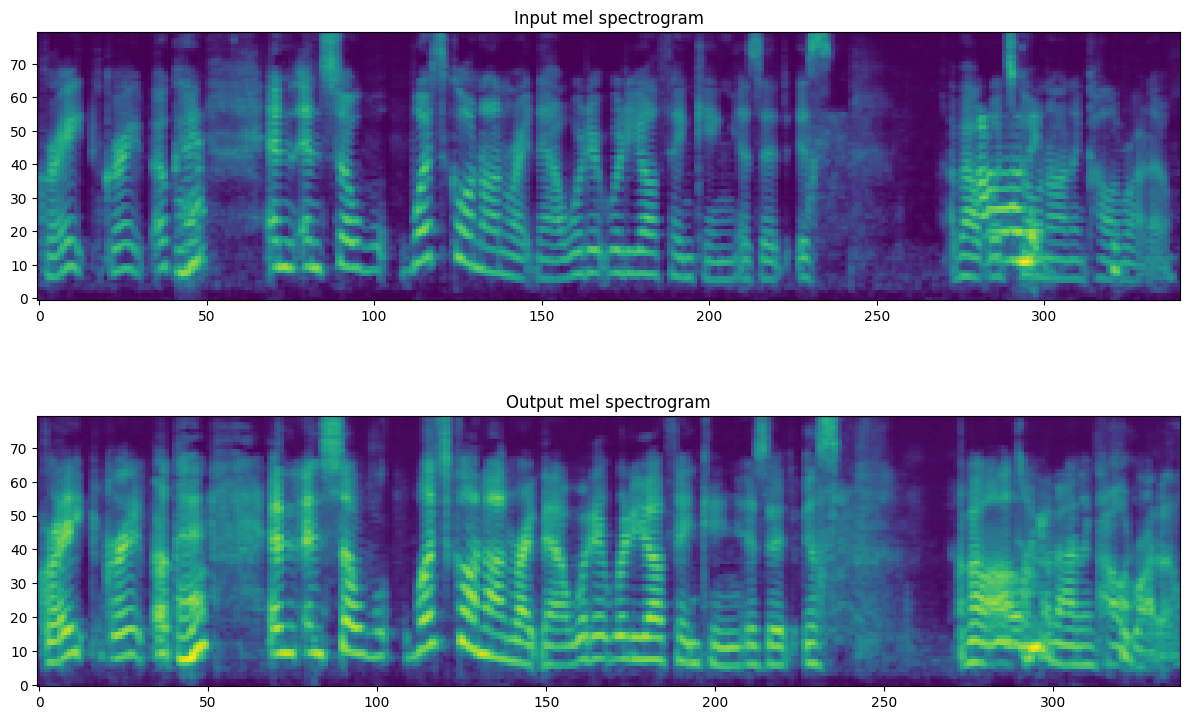

In [14]:
plot_model_output(t, "tkn_evc_xlsr_yin", emo_level=7)

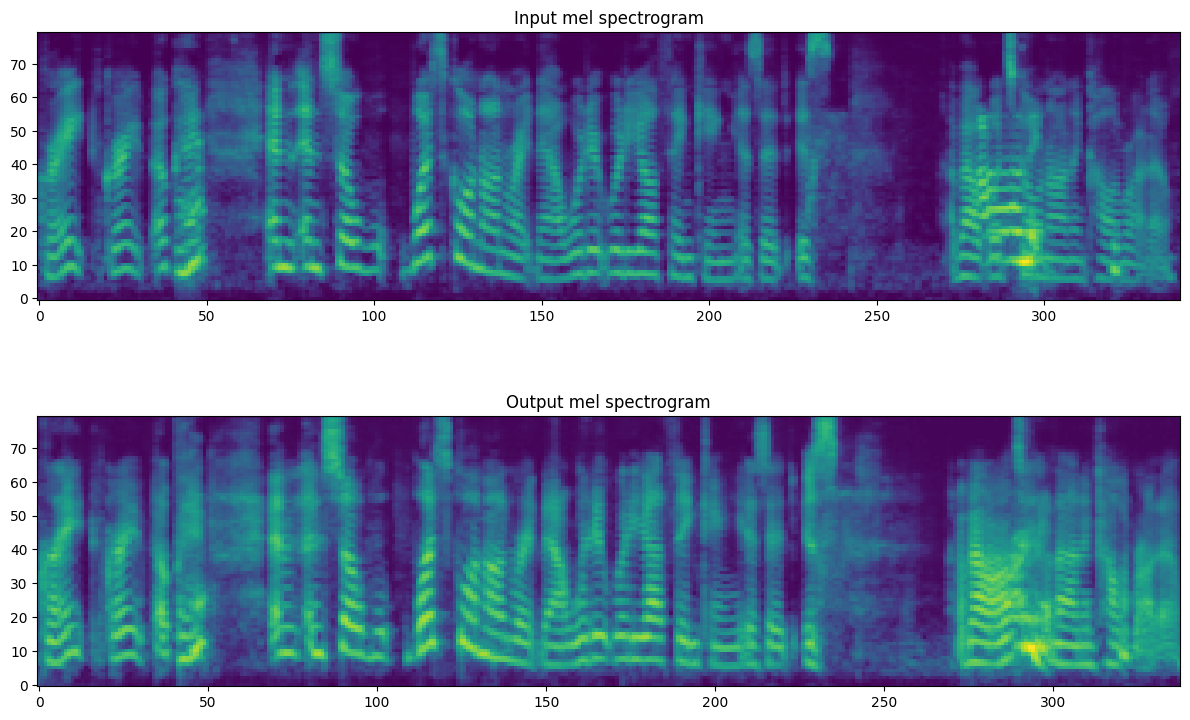

In [15]:
plot_model_output(t, "tkn_evc_xlsr_yin", emo_level=1)